# Archery Trainingslogbook Analysis

This notebook will answer the following questions:
- some statistics with more insight on the entries like:
    - How many entries of each type
    - Percentage of Trainings, Competitions, Stages, Fysieke Training, Mentale Training
    - Information based on an archer:
        - Record scores
        - Number of sessions (based on an inputfield) with a good mental feeling?
        - Average score in 70m competitions
        - Personal average number of arrows of each session (based on an inputfield)
    - All trainings over X arrows:
- How many arrows per month in a chart. 
    - Chart that displays the number of arrows trained
- corelation score with weather data 
    - Impact of the weather conditions in scoring

## Understanding the dataset
The logbook dataset should be the result of every form entry after each training. As form tool I used CognitoForms and since there weren't enough records yet I used a tool called Mockaroo and some help of a friend for generating realistic data.
The dataset contains multiple fields:

- **LogboekId**: Is the ID of every entry
- **Voornaam** and **achternaam**: Refers to the person
- **Datum**: Is the date of the training
- **Starttijd** and **Eindtijd**: Refers to the duration of the training. starting at **Starttijd**, ending at **Eindtijd**
- **Soort**: Refers to the type whether it's a normal training/competition(wedstrijd)/stage/mental training(mentale training)/fysical training(fysieke training)
- **Boogtype**: Is the type of bow the archer was using
- **TypeWedstrijd**: Name of the competition
- **TypeStage**: Name of the stage
- **Afstand**: What distance the archer was shooting
- **TypeBlazoen**: What target type that was used
- **AantalPijlen**: Is the number of arrows shot
- **Score**: Is the score shot in a competition
- **Rankingkwalificatie**: The achieved place in a competition
- **Mentaal**: Refers to the mental feeling of the archer that session
- **Fysiek**: Refers to the fysical feeling of the archer that session
- **AlgemeenGevoel**: Refers to the general feeling of the archer that session
- **Notities**: Possible notes about that session
- **AanpassingenMateriaal**: Possible notes about (changing) equipement
- **AanpassingenTechniek**: Possible notes about (changing) technique

And some other auto generated fields of the form tool that was used (Boogtype_Quantity, Afstand_Quantity, Afstand2, TypeBlazoen2, TypeBlazoen3, Mentaal_Quantity, Fysiek_Quantity, AlgemeenGevoel_Quantity, AanpassingenAanMateriaal, AanpassingenAanTechniek, Entry_Status, Entry_DateCreated, Entry_DateSubmitted, Entry_DateUpdated)    


Some of the above mentioned columns have dependencies, like official outdoor competitions are mostly shot at 70m when indoor competitions and trainings are always at 18m distance. This made it hard to generate random data. Given the functionalities of the tool it wasn't possible to generate a fully realistic dataset but I have limited myself generating:
- more archers (300) to cover up a period of 3 years to match up better with the interval of the weather data. Each archer has it's own personal average. So it's possible to do realistic analysis
- only 2x70m and youth competitions as **TypeWedstrijd**, since they have the same competition format
- just 70m distances -> so this implies only 120cm targets 
- creating a scenario for **AantalPijlen** because you shoot a different number of arrows on training than in competition where it's a more constant number
- training from 18u-19u for **Starttijd** to 20u-21u for **Eindtijd**

## Download and install Spark

In [ ]:
!ls

In [1]:
!pip install pyspark
#!pip install ipywidgets

     |████████████████████████████████| 204.2 MB 20 kB/s  eta 0:00:0111
     |████████████████████████████████| 198 kB 40.2 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=8b07149de9383aca1ba2d781fd4032801e211804e5f1f73bc3b0c2981f5a26a7
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# imports
import os
import numpy as np # linear algebra
import ipywidgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from datetime import datetime

from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
# creating the sparksession 
spark = SparkSession.builder.master("local").appName("Logbook_archery").getOrCreate()
spark

#sc = spark.sparkContext
#sc
#sqlContext = SQLContext(spark.sparkContext)
#sqlContext

## Load the data from a file into a dataframe

In [4]:
# Define the schema for the logbook data
schema_logbook = StructType([
    StructField("Logboek_Id", IntegerType(), nullable=True),
    StructField("Voornaam", StringType(), nullable=True),
    StructField("Achternaam", StringType(), nullable=True),
    StructField("Datum", StringType(), nullable=True),
    StructField("Starttijd", StringType(), nullable=True),
    StructField("Eindtijd", StringType(), nullable=True),
    StructField("Soort", StringType(), nullable=True),
    StructField("Boogtype", StringType(), nullable=True),
    StructField("Boogtype_Quantity", StringType(), nullable=True),
    StructField("TypeWedstrijd", StringType(), nullable=True),
    StructField("TypeStage", StringType(), nullable=True),
    StructField("Afstand", IntegerType(), nullable=True),
    StructField("Afstand_Quantity", IntegerType(), nullable=True),
    StructField("Afstand2", IntegerType(), nullable=True),
    StructField("TypeBlazoen", StringType(), nullable=True),
    StructField("TypeBlazoen2", StringType(), nullable=True),
    StructField("TypeBlazoen3", StringType(), nullable=True),
    StructField("AantalPijlen", IntegerType(), nullable=True),
    StructField("Score", IntegerType(), nullable=True),
    StructField("Rankingkwalificatie", IntegerType(), nullable=True),
    StructField("Mentaal", StringType(), nullable=True),
    StructField("Mentaal_Quantity", StringType(), nullable=True),
    StructField("Fysiek", StringType(), nullable=True),
    StructField("Fysiek_Quantity", StringType(), nullable=True),
    StructField("AlgemeenGevoel", StringType(), nullable=True),
    StructField("AlgemeenGevoel_Quantity", StringType(), nullable=True),
    StructField("Notities", StringType(), nullable=True),
    StructField("AanpassingenAanMateriaal", StringType(), nullable=True),
    StructField("AanpassingenMateriaal", StringType(), nullable=True),
    StructField("AanpassingenAanTechniek", StringType(), nullable=True),
    StructField("AanpassingenTechniek", StringType(), nullable=True),
    StructField("Entry_Status", StringType(), nullable=True),
    StructField("Entry_DateCreated", StringType(), nullable=True),
    StructField("Entry_DateSubmitted", StringType(), nullable=True),
    StructField("Entry_DateUpdated", StringType(), nullable=True)
]
)

In [5]:
# Define the schema for weather data 
schema_weather = StructType([
    StructField("FID", StringType(), nullable=True),
    StructField("code", IntegerType(), nullable=True),
    StructField("DatumEnUur", TimestampType(), nullable=True),
    StructField("air_pressure", IntegerType(), nullable=True),
    StructField("air_temperature", IntegerType(), nullable=True),
    StructField("relative_humidity", IntegerType(), nullable=True),
    StructField("precipitation", IntegerType(), nullable=True),
    StructField("wind_speed", IntegerType(), nullable=True),
    StructField("the_geom", StringType(), nullable=True)]
)

### Load data from Cognito (real data) into a dataframe

In [6]:
csvCognitoFilePath = "../input/cognito-export-tocsvv2/1 Logboek_CognitoExport.csv"
logbookData_df = spark.read.option("header", "true").csv(path=csvCognitoFilePath, sep=',', multiLine=True, schema=schema_logbook).cache()

#Parsing strings to correct datatypes
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
logbookData_df = logbookData_df.withColumn("Datum", to_date(unix_timestamp(col("Datum"), "MM/dd/yyyy").cast('timestamp')))
logbookData_df = logbookData_df.withColumn("Starttijd", from_unixtime(unix_timestamp(col("Starttijd"), "hh:mm:ss a")).cast("timestamp"))
logbookData_df = logbookData_df.withColumn("Starttijd", date_format("Starttijd", "HH:mm:ss"))

#logbookData_df.select("Starttijd").show()
#logbookData_df.count()
#logbookData_df.select('Entry_DateUpdated', 'Datum', 'Starttijd', 'AantalPijlen').show()


### Load generated data into a dataframe

In [7]:
csvGeneratedFilePath = "../input/generateddata100k/gendata100k.csv"
generatedData_df = spark.read.option("header", "false").csv(path=csvGeneratedFilePath, sep=',', multiLine=True, schema=schema_logbook).cache()

#Parsing strings to DateTypes
generatedData_df = generatedData_df.withColumn("Datum", to_date(unix_timestamp(col("Datum"), "yyyy-MM-dd").cast('timestamp')))
generatedData_df = generatedData_df.withColumn("Starttijd", date_format("Starttijd", "HH:mm:ss"))

mergedData_dfWithoutPreprocessing = logbookData_df.union(generatedData_df)
#generatedData_df.select("Starttijd").show()
#generatedData_df.count()
#generatedData_df.select('Entry_DateUpdated', 'Datum', 'Starttijd', 'AantalPijlen').show()


In [8]:
# remove unrealistic data from generatedData_df (with scores +360 points)
voor = generatedData_df.count()
generatedData_df = generatedData_df.filter(generatedData_df.Score < 360)
na = generatedData_df.count()

print("Er werden " + str(voor - na) + " foutieve rijen gegenereerd door de tool en zijn bijgevolg verwijderd")


Er werden 10029 foutieve rijen gegenereerd door de tool en zijn bijgevolg verwijderd


### Merge the 2 datasets into 1 Dataframe

In [10]:
# merge the 2 dataframes
mergedData_df = logbookData_df.union(generatedData_df)

#mergedData_df.count()
#mergedData_df.select('Entry_DateUpdated', 'Datum', 'Starttijd', 'AantalPijlen').show()

90429

### Load weather data into a dataframe

In [12]:
csvWeatherFilePath = "../input/weatherdatav2/WeatherData1Hourv2.csv"
weatherData_df = spark.read.option("header", "true").csv(path=csvWeatherFilePath, sep=',', multiLine=True, schema=schema_weather).cache()

#weatherData_df.select('FID','DatumEnUur', 'code', 'wind_speed').show(30, truncate = False)
#weatherData_df.count()

+------------------------------------+-------------------+----+----------+
|FID                                 |DatumEnUur         |code|wind_speed|
+------------------------------------+-------------------+----+----------+
|aws_1hour.6418.2008-03-19 00:00:00.0|2008-03-19 00:00:00|6418|6         |
|aws_1hour.6472.2008-03-19 00:00:00.0|2008-03-19 00:00:00|6472|3         |
|aws_1hour.6418.2017-11-18 00:00:00.0|2017-11-18 00:00:00|6418|5         |
|aws_1hour.6472.2017-11-18 00:00:00.0|2017-11-18 00:00:00|6472|2         |
|aws_1hour.6418.2017-11-18 01:00:00.0|2017-11-18 01:00:00|6418|6         |
|aws_1hour.6472.2017-11-18 01:00:00.0|2017-11-18 01:00:00|6472|2         |
|aws_1hour.6418.2017-11-18 02:00:00.0|2017-11-18 02:00:00|6418|6         |
|aws_1hour.6472.2017-11-18 02:00:00.0|2017-11-18 02:00:00|6472|1         |
|aws_1hour.6418.2017-11-18 03:00:00.0|2017-11-18 03:00:00|6418|7         |
|aws_1hour.6472.2017-11-18 03:00:00.0|2017-11-18 03:00:00|6472|2         |
|aws_1hour.6418.2017-11-1

In [13]:
# were is my weather data coming from?
import folium

locaties = weatherData_df.select('the_geom').distinct().rdd.map(lambda row : row[0]).collect()

locatie = [50.846665, 4.352556]
kaart = folium.Map(location=locatie, zoom_start=8)
tooltip = 'meer informatie'

for i in range((len(locaties))):
    locatie = locaties[i]
    locatie = locatie[7:]
    locatie = locatie[:-1]
 
    lonlat = locatie.split()
    lon = lonlat[1]
    lat = lonlat[0]
    
    folium.Marker([lon, lat], popup='<i>Locatie weerstation </i>',icon=folium.Icon(icon='cloud'), tooltip=tooltip).add_to(kaart)

kaart

In [14]:
weatherData_df.select('the_geom').distinct().show(truncate = False)

# verwijderen met datgene dat het verste van antwerpen ligt / 
# weerstation 1 wordt verwijderd aangezien er aan de zee gemiddeld meer wind is.
weatherData_df = weatherData_df.filter(weatherData_df.the_geom == 'POINT (5.255236 50.193663)')
#weatherData_df = weatherData_df.filter(weatherData_df.the_geom == 'POINT (3.201846 51.347375)')

weatherData_df.select('the_geom').distinct().show(truncate = False)


+--------------------------+
|the_geom                  |
+--------------------------+
|POINT (5.255236 50.193663)|
|POINT (3.201846 51.347375)|
+--------------------------+

+--------------------------+
|the_geom                  |
+--------------------------+
|POINT (5.255236 50.193663)|
+--------------------------+



## Data Preprocessing

### Append the weather data on mergedData_df

In [15]:
# add kolom datumUurKolom from Datum and Starttijd and delete minutes and seconds to join based on hours
datumUurKolom = concat(split(mergedData_df.Datum, "T")[0], lit(" "), mergedData_df.Starttijd)
mergedData_df = mergedData_df.withColumn("DatumMetUur", from_unixtime(unix_timestamp(datumUurKolom, "yyyy-MM-dd HH:mm:ss")).cast("timestamp")) 

#uren afronden
dt_truncated = ((round(unix_timestamp(col("DatumMetUur")) / 60 / 60) * 60 * 60).cast("timestamp"))
mergedData_df = mergedData_df.withColumn("DatumMetUurAfgerond", dt_truncated)


mergedData_df.count()
mergedData_df.select('DatumMetUurAfgerond').na.drop().count()

90429

In [16]:
# join
joineddf = mergedData_df.join(weatherData_df, mergedData_df.DatumMetUurAfgerond == weatherData_df.DatumEnUur, 'inner')

#joineddf.select('Soort', 'wind_speed', 'DatumMetUurAfgerond','DatumEnUur').show()
joineddf.count()

42643

In [17]:
# drop unused columns
joineddf.drop(
    'Logboek_Id', 
    'Boogtype_Quantity', 
    'Afstand_Quantity', 
    'Afstand2', 
    'TypeBlazoen2', 
    'TypeBlazoen3', 
    'Mentaal_Quantity', 
    'Fysiek_Quantity', 
    'AlgemeenGevoel_Quantity', 
    'Entry_Status', 
    'Entry_DateCreated', 
    'Entry_DateUpdated',
    'FID',
    'code',
    'the_geom'
)

DataFrame[Voornaam: string, Achternaam: string, Datum: date, Starttijd: string, Eindtijd: string, Soort: string, Boogtype: string, TypeWedstrijd: string, TypeStage: string, Afstand: int, TypeBlazoen: string, AantalPijlen: int, Score: int, Rankingkwalificatie: int, Mentaal: string, Fysiek: string, AlgemeenGevoel: string, Notities: string, AanpassingenAanMateriaal: string, AanpassingenMateriaal: string, AanpassingenAanTechniek: string, AanpassingenTechniek: string, Entry_DateSubmitted: string, DatumMetUur: timestamp, DatumMetUurAfgerond: timestamp, DatumEnUur: timestamp, air_pressure: int, air_temperature: int, relative_humidity: int, precipitation: int, wind_speed: int]

## Exploratory data analysis

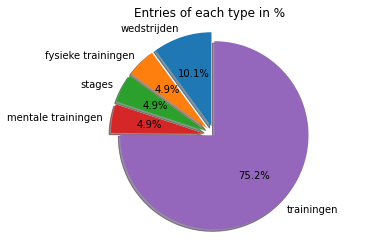

In [18]:
#- How many entries of each type?
#mergedData_dfWithoutPreprocessing.groupBy('Soort').count().show()
import matplotlib
matplotlib.axes.Axes.pie
matplotlib.pyplot.pie
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'wedstrijden', 'fysieke trainingen', 'stages', 'mentale trainingen', 'trainingen'
size_wedstrijd = mergedData_dfWithoutPreprocessing.filter(col('Soort') == 'Wedstrijd').count()
size_fys_trainingen = mergedData_dfWithoutPreprocessing.filter(col('Soort') == 'Fysieke training').count()
size_stage = mergedData_dfWithoutPreprocessing.filter(col('Soort') == 'Stage').count()
size_men_trainingen = mergedData_dfWithoutPreprocessing.filter(col('Soort') == 'Mentale training').count()
size_training = mergedData_dfWithoutPreprocessing.filter(col('Soort') == 'Training').count()

sizes = [size_wedstrijd, size_fys_trainingen, size_stage, size_men_trainingen, size_training ]
explode = (0.1, 0.1, 0.1, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title("Entries of each type in %")

plt.show()


### Percentage of Trainings, Competitions, Stages, Fysieke Training, Mentale Training:

In [19]:
opties = joineddf.select('Soort').distinct().rdd.map(lambda row : row[0]).collect()
w_soort = ipywidgets.RadioButtons(options= opties)
w_SoortBox = ipywidgets.Box(
    [
        ipywidgets.Label(value='Maak een keuze uit volgende mogelijkheden:'),
        w_soort
    ]
)

w_SoortBox

Box(children=(Label(value='Maak een keuze uit volgende mogelijkheden:'), RadioButtons(options=('Training', 'We…

In [ ]:
# percentage of 'soort' values based on radiobutton input
#percentage = joineddf.filter(col('Soort') == w_soort.value).count() / joineddf.select('Soort').count()

#print("Het percentage van " + w_soort.value + " bedraagt " + str(percentage))

### Information based on a person:


In [20]:
#met mergedData_df omdat er meer gegevens in staan door de inner join met weatherData_df in de joineddf
#namecombobox
names = mergedData_df.select('Voornaam').distinct().sort(col('Voornaam')).rdd.map(lambda row : row[0]).collect()

w_Person = ipywidgets.Dropdown(
    options= names,
    description='Archer:'
)
#w_Person

#competitioncombobox
competitions = mergedData_df.select('TypeWedstrijd').distinct().sort(col('Typewedstrijd')).rdd.map(lambda row : row[0]).collect()

w_competitions = ipywidgets.Dropdown(
    options= competitions,
    description='competition format:'
)
#w_competitions

searchPB = ipywidgets.VBox(children = [w_Person,w_competitions])
searchPB


In [21]:
# record score
pb = mergedData_df.filter(mergedData_df.Voornaam == w_Person.value).filter(mergedData_df.TypeWedstrijd == w_competitions.value).select(max(col('Score'))).collect()[0][0]
print(w_Person.value + " heeft een record van: " + str(pb) + " op een " + w_competitions.value + " wedstrijd.")

Ade heeft een record van: 357 op een jeugdwedstrijd wedstrijd.


In [22]:
# What date did the archers shoot their personal best?
recordsDF = mergedData_df.select('Voornaam','Achternaam',"score",'Datum').groupby('Voornaam').agg(max(col('Score')).alias("Topscore"))
recordsDF.show()

#all personal bests:

+---------+--------+
| Voornaam|Topscore|
+---------+--------+
|     Reta|     355|
| Shurwood|     352|
|    Ginny|     343|
|  Terrijo|     347|
|  Laraine|     357|
|    Ruben|     352|
|   Karmen|     349|
|Marmaduke|     341|
|   Salomi|     349|
|   Wildon|     358|
| Violetta|     357|
|   Randee|     344|
|  Raynard|     344|
|   Marion|     353|
|     Agna|     354|
|     Tori|     350|
|    Eddie|     353|
|    Nikos|     351|
|   Korney|     346|
|      Kit|     351|
+---------+--------+
only showing top 20 rows



In [24]:
#- Number of sessions with a good mental feeling? (based on w_soort)
mergedData_df.filter(col('Voornaam') == w_Person.value).filter(col('Soort') == w_soort.value).filter(col('Mentaal') == 'goed').groupBy('Mentaal','Soort').count().show()


+-------+---------+-----+
|Mentaal|    Soort|count|
+-------+---------+-----+
|   goed|Wedstrijd|    6|
+-------+---------+-----+



In [26]:
#- Archers average score in 70m competitions
mergedData_df.filter(col('voornaam') == w_Person.value).filter(col('Soort') == 'Wedstrijd').filter(col('Afstand') == '70').select(mean("Score")).show()

+-----------------+
|       avg(Score)|
+-----------------+
|286.4516129032258|
+-----------------+



In [28]:
#- Personal average number of arrows on each session (based on the w_soort inputfield)
gemiddeldAantalPijlen = mergedData_df.filter(col('voornaam') == w_Person.value).filter(col('Soort') == w_soort.value).select(avg("AantalPijlen")).collect()[0][0]
print("gemiddeld aantal pijlen voor " + w_Person.value + " op een " + w_soort.value + ": " + str(gemiddeldAantalPijlen))

gemiddeld aantal pijlen voor Jarno op een Training: 100.97069597069597


#### All trainings over X arrows:

In [29]:
w_AantalPijlen = ipywidgets.IntSlider(
    value=100,
    min=0,
    max=450,
    step=1,
    description='Aantal pijlen:',
    
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
w_AantalPijlen


IntSlider(value=100, continuous_update=False, description='Aantal pijlen:', max=450)

In [31]:
# All trainings over X arrows based on slider input
mergedData_df.filter(logbookData_df['AantalPijlen'] > w_AantalPijlen.value).select('Voornaam', 'Datum', 'Starttijd', 'Eindtijd', 'AantalPijlen').show()

+--------+----------+---------+----------+------------+
|Voornaam|     Datum|Starttijd|  Eindtijd|AantalPijlen|
+--------+----------+---------+----------+------------+
|   Jarno|2019-10-27| 08:15:00|9:15:00 PM|         400|
+--------+----------+---------+----------+------------+



### Chart that displays the number of arrows trained

In [32]:
w_Year = ipywidgets.IntSlider(
    value=2019,
    min=2017,
    max=2020,
    step=1,
    description='Jaartal:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
#w_Year


w_Name = ipywidgets.Text(
    value='test',
    placeholder='Geef de naam waarop je wil zoeken',
    description='Naam:',
    disabled=False
)
def onSubmit(change):
    print("Hello {}!".format(w_Name.value))

w_Name.on_submit(onSubmit)
#w_Name

w_box = ipywidgets.Box(children = [w_Year,w_Name])
w_box

Box(children=(IntSlider(value=2019, continuous_update=False, description='Jaartal:', max=2020, min=2017), Text…

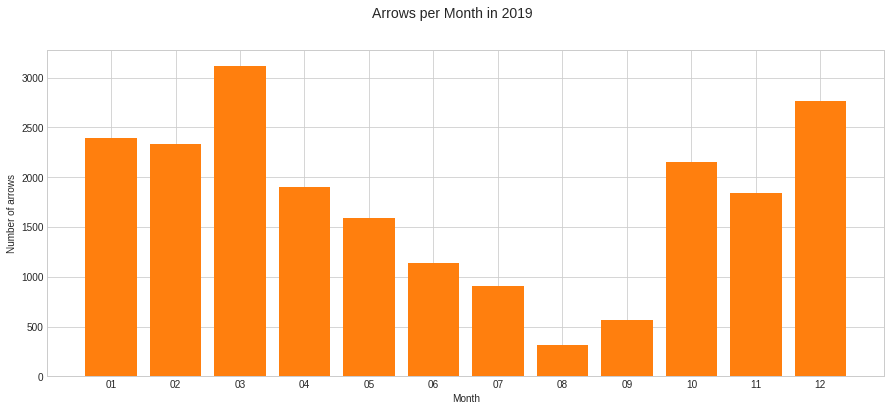

In [33]:
# How many arrows did I shoot per month in 2019?
%matplotlib inline
#import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
plt.style.use('seaborn-whitegrid')

x=[]
y=[]

df_name = mergedData_df.filter(mergedData_df.Voornaam == w_Name.value)
df_with_year = df_name.withColumn("Datum",to_timestamp(col("Datum"))).withColumn("year", date_format(col("Datum"), "yyyy"))
df_with_year = df_with_year.filter(df_with_year.year == w_Year.value)
df_with_month = df_with_year.withColumn("Datum",to_timestamp(col("Datum"))).withColumn("month", date_format(col("Datum"), "MM"))
count_per_month_df = df_with_month.groupby('month').sum("AantalPijlen").sort(["month"])

rangelength = count_per_month_df.count()
for i in range(rangelength):
    x.append(count_per_month_df.select('month').collect()[i][0])

for i in range(rangelength):
    y.append(count_per_month_df.select('sum(AantalPijlen)').collect()[i][0])

#figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig1 = plt.figure(figsize=(15, 6))
fig1.suptitle('Arrows per Month in ' + str(w_Year.value), fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('Month')
ax.set_ylabel('Number of arrows')
ax.bar(x, y, align='center')

plt.bar(x, y)
plt.show()


### Impact of the weather conditions in scoring

In [34]:
values = joineddf.select('Voornaam').distinct().sort(col('Voornaam')).rdd.map(lambda row : row[0]).collect()

w_ChosePersons = ipywidgets.SelectMultiple(
    options=values,
    #rows=10,
    description='select archers:'
)
w_ChosePersons

SelectMultiple(description='select archers:', options=('Abbott', 'Adda', 'Ade', 'Adela', 'Adelaide', 'Agna', '…

In [ ]:
archers = w_ChosePersons.value

print(archers)

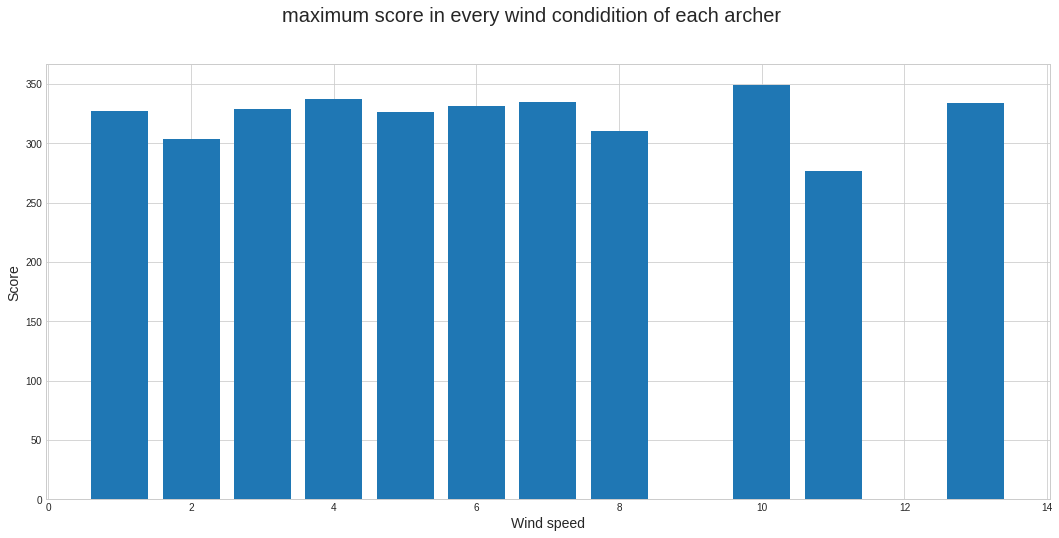

In [35]:
#max score of each archer in wind condition in a chart
archers = []
for i in range(len(w_ChosePersons.value)):
    archers.append(w_ChosePersons.value[i])

selectedArchersDf = joineddf.filter(col('Voornaam').isin(archers))

max_per_windspeed_per_person_df = selectedArchersDf.filter(col('Voornaam') == archers[0]).groupby('wind_speed', 'Voornaam').agg(max("Score").alias("max_score")).sort("wind_speed")
#max_per_windspeed_per_person_df.show()

x = max_per_windspeed_per_person_df.select("wind_speed").distinct().rdd.map(lambda row: row[0]).collect()


fig1 = plt.figure(figsize=(18, 8))
fig1.suptitle('maximum score in every wind condidition of each archer', fontsize=20)
ax = fig1.add_subplot(111)
ax.set_xlabel('Wind speed', fontsize=14)
ax.set_ylabel('Score', fontsize=14)


# loopen rond bar
#for i in range(len(archers)):
y = max_per_windspeed_per_person_df.select('max_score').rdd.map(lambda row: row[0]).collect()
ax.bar(x, y)
               

plt.show()


## EXTRA

In [ ]:
#tellen en weergeven hoeveel nullwaardes er in de dataframe zitten
def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

null_columns_count_list = null_value_count(mergedData_df)
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show()